<a href="https://colab.research.google.com/github/ThisalFernando/AFLab03/blob/main/Finalized_CAD_Ischemia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 01: Environmental Setup**

In [65]:
pip install wfdb numpy scipy torch scikit-learn matplotlib pandas

# **Step 02: Imports**

In [66]:
import os
import wfdb
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from scipy.signal import butter, filtfilt, resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score


# **Step 03: Mount Google Drive**

In [67]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Step 04: Paths**

In [68]:
PTBXL_PATH = "/content/drive/MyDrive/ECG_Datasets/PTBXL"
EDB_PATH   = "/content/drive/MyDrive/ECG_Datasets/European-STT"

SAVE_PATH = "/content/drive/MyDrive/ECG_Datasets"
PTB_X = os.path.join(SAVE_PATH, "X_ptb.npy")
PTB_Y = os.path.join(SAVE_PATH, "y_ptb.npy")
EDB_X = os.path.join(SAVE_PATH, "X_edb.npy")
EDB_Y = os.path.join(SAVE_PATH, "y_edb.npy")

PTB_CKPT = os.path.join(SAVE_PATH, "ptbxl_checkpoint.pt")
EDB_CKPT = os.path.join(SAVE_PATH, "edb_checkpoint.pt")


# **Step 05: Signal Preprocessing**

In [69]:
def bandpass_filter(signal, fs=250):
    b, a = butter(4, [0.5/(fs/2), 40/(fs/2)], btype='band')
    return filtfilt(b, a, signal, axis=0)

def normalize(signal):
    return (signal - np.mean(signal)) / (np.std(signal) + 1e-8)

def resample_signal(signal, orig_fs, target_fs=250):
    n_samples = int(len(signal) * target_fs / orig_fs)
    return resample(signal, n_samples)


# **Step 06: ECG Segmentation**

In [70]:
def segment_signal(signal, window=1250, step=1250):
    return np.array([
        signal[i:i+window]
        for i in range(0, len(signal)-window, step)
    ])


# **Step 07: PTB-XL Loader (PRETRAINING)**

Load metadata

In [71]:
meta = pd.read_csv(os.path.join(PTBXL_PATH, "ptbxl_database.csv"))
meta = meta.sample(3000, random_state=42)


Label mapping (ischemia-related)

In [72]:
def is_ischemia(row):
    scp = eval(row["scp_codes"])
    return int(any(k in scp for k in ["ISC_", "MI"]))


Load PTB-XL ECG

In [73]:
def load_ptbxl_record(record_path):
    record = wfdb.rdrecord(record_path)
    signal = record.p_signal[:, [1, 6]]  # Lead II, V5
    signal = resample_signal(signal, record.fs)
    signal = bandpass_filter(signal)
    signal = normalize(signal)
    return segment_signal(signal)



# **Step 08: Build or Load Preprocessed PTB-XL**

In [74]:
if os.path.exists(PTB_X) and os.path.exists(PTB_Y):
    print("Loading saved PTB-XL data...")
    X_ptb = np.load(PTB_X)
    y_ptb = np.load(PTB_Y)

else:
    print("Processing PTB-XL from scratch...")
    X_ptb, y_ptb = [], []

    for _, row in meta.iterrows():
        try:
            record_path = os.path.join(PTBXL_PATH, row["filename_hr"])
            segments = load_ptbxl_record(record_path)

            label = int(any(
                k.startswith(("ISC", "MI"))
                for k in eval(row["scp_codes"]).keys()
            ))

            X_ptb.extend(segments)
            y_ptb.extend([label] * len(segments))

        except:
            continue

    X_ptb = np.array(X_ptb)
    y_ptb = np.array(y_ptb)

    np.save(PTB_X, X_ptb)
    np.save(PTB_Y, y_ptb)

print("PTB-XL samples:", len(X_ptb))


Loading saved PTB-XL data...
PTB-XL samples: 3000


In [75]:
print("PTB-XL segments:", len(X_ptb))
print("PTB-XL labels:", len(y_ptb))


PTB-XL segments: 3000
PTB-XL labels: 3000


# **Step 09: PyTorch Dataset**

In [76]:
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


# **Step 10: CNN-LSTM Model**

In [77]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super().__init__()

        # self.cnn = nn.Sequential(
        #     nn.Conv1d(2, 32, 7, padding=3),
        #     nn.ReLU(),
        #     nn.MaxPool1d(2),
        #     nn.Conv1d(32, 64, 5, padding=2),
        #     nn.ReLU(),
        #     nn.MaxPool1d(2)
        # )

        self.cnn = nn.Sequential(
            nn.Conv1d(2, 32, 7, padding=3),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2),
            nn.Conv1d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(0.2)
        )

        self.lstm = nn.LSTM(64, 64, batch_first=True)
        # self.fc = nn.Sequential(
        #     nn.Linear(64, 1),
        #     nn.Sigmoid()
        # )
        self.fc = nn.Linear(64, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.cnn(x)
        x = x.permute(0, 2, 1)
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1]).squeeze()


# **Step 11: Pretraining on PTB-XL**

In [78]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_ptb, y_ptb, test_size=0.2, stratify=y_ptb, random_state=42
)

train_ds = ECGDataset(X_tr, y_tr)
val_ds   = ECGDataset(X_val, y_val)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False)

model = CNN_LSTM()
pos_weight = torch.tensor(
    (len(y_tr) - np.sum(y_tr)) / (np.sum(y_tr) + 1e-8),
    dtype=torch.float32
)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

start_epoch = 0
if os.path.exists(PTB_CKPT):
    ckpt = torch.load(PTB_CKPT)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["opt"])
    start_epoch = ckpt["epoch"] + 1
    print("Resuming PTB-XL training from epoch", start_epoch)

best_val_auc = 0.0
for epoch in range(start_epoch, 5):
    model.train()
    for x, y in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()

    # torch.save({
    #     "epoch": epoch,
    #     "model": model.state_dict(),
    #     "opt": optimizer.state_dict()
    # }, PTB_CKPT)

    # print(f"PTB-XL Epoch {epoch+1}, Loss: {loss.item():.4f}")

    # model.eval()
    # val_logits, val_labels = [], []

    # with torch.no_grad():
    #     for x, y in val_loader:
    #         val_logits.append(model(x))
    #         val_labels.append(y)

    # val_logits = torch.cat(val_logits)
    # val_labels = torch.cat(val_labels)
    # val_auc = roc_auc_score(
    #     val_labels.cpu().numpy(),
    #     torch.sigmoid(val_logits).cpu().numpy()
    # )

    # print("Validation AUC:", round(val_auc, 3))

    # Validation
    model.eval()
    val_logits, val_labels = [], []
    with torch.no_grad():
        for x, y in val_loader:
            val_logits.append(model(x))
            val_labels.append(y)

    val_logits = torch.cat(val_logits)
    val_labels = torch.cat(val_labels)
    val_probs = torch.sigmoid(val_logits)
    val_auc = roc_auc_score(val_labels.cpu().numpy(), val_probs.cpu().numpy())
    print(f"PTB-XL Epoch {epoch+1} → Validation AUC: {val_auc:.3f}")

    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save({"epoch": epoch, "model": model.state_dict(), "opt": optimizer.state_dict()}, PTB_CKPT)
        print("Saved best PTB-XL checkpoint.")



Resuming PTB-XL training from epoch 4
PTB-XL Epoch 5 → Validation AUC: 0.622
Saved best PTB-XL checkpoint.


# **Step 12: Freeze CNN (Transfer Learning)**

In [79]:
for p in model.cnn.parameters():
    p.requires_grad = False



# **Step 13: Load European ST-T**

In [80]:
def load_edb_record(name):
    rec = wfdb.rdrecord(os.path.join(EDB_PATH, name))
    ann = wfdb.rdann(os.path.join(EDB_PATH, name), 'atr')

    # signal = normalize(bandpass_filter(rec.p_signal))
    # segments = segment_signal(signal)
    # labels = np.zeros(len(segments))

    # Keep same leads as PTB-XL
    signal = rec.p_signal[:, :2]  # Lead II and V5
    signal = resample_signal(signal, rec.fs)  # optional
    signal = bandpass_filter(signal)
    signal = normalize(signal)

    segments = segment_signal(signal)
    labels = np.zeros(len(segments))

    for s in ann.sample:
        idx = s // 1250
        if idx < len(labels):
            labels[idx] = 1

    return segments, labels

if os.path.exists(EDB_X) and os.path.exists(EDB_Y):
    print("Loading cached European ST-T...")
    X_edb = np.load(EDB_X)
    y_edb = np.load(EDB_Y)
else:
    X_edb, y_edb = [], []
    files = [f for f in os.listdir(EDB_PATH) if f.endswith(".hea")]
    for f in files:
        s, l = load_edb_record(f.replace(".hea", ""))
        X_edb.extend(s)
        y_edb.extend(l)
    X_edb = np.array(X_edb)
    y_edb = np.array(y_edb)
    np.save(EDB_X, X_edb)
    np.save(EDB_Y, y_edb)


# **Step 14: Fine-Tune on European ST-T**

In [81]:
X_train, X_val, y_train, y_val = train_test_split(
    X_edb, y_edb, test_size=0.2, stratify=y_edb, random_state=42
)

edb_train_ds = ECGDataset(X_train, y_train)
edb_val_ds   = ECGDataset(X_val, y_val)

edb_train_loader = DataLoader(edb_train_ds, batch_size=32, shuffle=True)
edb_val_loader   = DataLoader(edb_val_ds, batch_size=32, shuffle=False)

# Freeze the entire CNN backbone
for p in model.cnn.parameters():
    p.requires_grad = False

# Only fine-tune LSTM + FC layers
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-5
)

# BCEWithLogitsLoss with pos_weight for imbalance
pos_weight = torch.tensor((len(y_train) - np.sum(y_train)) / np.sum(y_train + 1e-8), dtype=torch.float32)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

start_epoch = 0
if os.path.exists(EDB_CKPT):
    ckpt = torch.load(EDB_CKPT)
    model.load_state_dict(ckpt["model"])
    optimizer.load_state_dict(ckpt["opt"])
    start_epoch = ckpt["epoch"] + 1
    print("Resuming EDB training from epoch", start_epoch)

# Fine-tuning with validation
best_val_loss = float('inf')
for epoch in range(start_epoch, 5):
    model.train()
    train_loss = 0.0

    for x, y in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(y)

    train_loss /= len(train_ds)

    # Validation
    model.eval()
    val_loss = 0.0
    val_preds, val_labels = [], []
    with torch.no_grad():
        for x, y in val_loader:
            logits = model(x)
            loss = criterion(logits, y)
            val_loss += loss.item() * len(y)
            val_preds.append(torch.sigmoid(logits))
            val_labels.append(y)
    val_loss /= len(val_ds)
    val_preds = torch.cat(val_preds)
    val_labels = torch.cat(val_labels)
    val_auc = roc_auc_score(val_labels.cpu().numpy(), val_preds.cpu().numpy())

    print(f"EDB Epoch {epoch+1} → Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.3f}")

    # Save checkpoint if validation improves
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            "epoch": epoch,
            "model": model.state_dict(),
            "opt": optimizer.state_dict()
        }, EDB_CKPT)
        print("Saved best model checkpoint.")


Resuming EDB training from epoch 5


# **Step 15: Inference**

In [105]:
# def predict_ecg_clinical(signal,
#                           fs=250,
#                           seg_len=1250,
#                           ischemia_threshold=0.5,
#                           min_consecutive_segments=2):
#     """
#     Clinical CAD inference:
#     - Detects sustained ischemic episodes
#     - Uses max episode probability, not mean
#     """

#     # --- Lead handling ---
#     if signal.shape[1] >= 7:      # PTB-XL style
#         signal = signal[:, [1, 6]]  # Lead II, V5
#     else:                         # European ST-T
#         signal = signal[:, :2]

#     # --- Preprocessing ---
#     signal = bandpass_filter(signal, fs)
#     signal = normalize(signal)
#     segments = segment_signal(signal, window=seg_len)

#     model.eval()
#     probs = []

#     with torch.no_grad():
#         for seg in segments:
#             logit = model(torch.tensor(seg).unsqueeze(0).float())
#             prob = torch.sigmoid(logit).item()
#             probs.append(prob)

#     probs = np.array(probs)

#     # --- Clinical ischemia detection ---
#     ischemic = probs >= ischemia_threshold

#     # Count consecutive ischemic segments
#     max_run = 0
#     run = 0
#     for x in ischemic:
#         if x:
#             run += 1
#             max_run = max(max_run, run)
#         else:
#             run = 0

#     cad_detected = max_run >= min_consecutive_segments

#     return {
#         "cad_detected": cad_detected,
#         "cad_probability": float(probs.max()),
#         "ischemic_burden": float(np.mean(ischemic)),
#         "max_consecutive_segments": int(max_run),
#         "segment_probs": probs
#     }

import matplotlib.pyplot as plt

def predict_ecg_clinical(signal,
                          fs=250,
                          seg_len=1250,
                          ischemia_threshold=0.5):
    """
    Predict ischemia probability for ECG signal using the model.

    Args:
        signal (np.array): ECG signal [samples, leads]
        fs (int): target sampling frequency
        seg_len (int): segment length in samples
        ischemia_threshold (float): probability threshold per segment

    Returns:
        dict: {
            'segment_probs': array of segment probabilities,
            'ischemic_burden': fraction of ischemic segments,
            'max_consecutive_segments': longest run of ischemic segments,
            'cad_probability': max segment probability
        }
    """

    # --- Lead selection ---
    if signal.shape[1] >= 7:
        signal = signal[:, [1, 6]]  # PTB-XL style (Lead II, V5)
    else:
        signal = signal[:, :2]      # European ST-T

    # --- Preprocessing ---
    signal = bandpass_filter(signal, fs)
    signal = normalize(signal)
    segments = segment_signal(signal, window=seg_len)

    # --- Predict per segment ---
    model.eval()
    probs = []

    with torch.no_grad():
        for seg in segments:
            logit = model(torch.tensor(seg).unsqueeze(0).float())
            prob = torch.sigmoid(logit).item()
            probs.append(prob)

    probs = np.array(probs)

    # --- Ischemia analysis ---
    ischemic = probs >= ischemia_threshold

    # Max consecutive ischemic segments
    max_run = 0
    run = 0
    for x in ischemic:
        if x:
            run += 1
            max_run = max(max_run, run)
        else:
            run = 0

    return {
        "segment_probs": probs,
        "ischemic_burden": float(np.mean(ischemic)),
        "max_consecutive_segments": int(max_run),
        "cad_probability": float(probs.max())
    }


def detect_cad_clinical(result,
                        prob_thresh=0.6,
                        burden_thresh=0.01,
                        consecutive_thresh=2):
    """
    Clinical CAD detection using robust logic:
    - Max segment probability
    - Overall ischemic burden
    - Optional consecutive segment requirement
    """
    cad_detected = (
        result["cad_probability"] >= prob_thresh or
        result["ischemic_burden"] >= burden_thresh or
        result["max_consecutive_segments"] >= consecutive_thresh
    )
    return cad_detected

def is_non_cad(result,
               prob_thresh=0.7,
               burden_thresh=0.05,
               consecutive_thresh=3):
    """
    Detect non-CAD ECG using strict clinical thresholds.
    """
    non_cad = (
        result["cad_probability"] < prob_thresh and
        result["ischemic_burden"] < burden_thresh and
        result["max_consecutive_segments"] < consecutive_thresh
    )
    return non_cad

def plot_ischemia(result, title="ECG Ischemic Probability"):
    """Optional plot for ischemic segments"""
    plt.figure(figsize=(10,3))
    plt.plot(result["segment_probs"], marker='o', label="Segment Probability")
    plt.axhline(0.5, color='r', linestyle='--', label="Threshold")
    plt.xlabel("Segment Index")
    plt.ylabel("Ischemia Probability")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# **Step 16: Testing CAD (Ischemia)**

Search on non-CAD ECG records

In [106]:
# List all records
files = [f.replace(".hea","") for f in os.listdir(EDB_PATH) if f.endswith(".hea")]

# Find records with no annotations (non-CAD)
non_cad_records = []
for f in files:
    ann = wfdb.rdann(os.path.join(EDB_PATH, f), 'atr')
    if len(ann.sample) == 0:
        non_cad_records.append(f)

print("Non-CAD records:", non_cad_records)

Non-CAD records: []


Test for CAD (Ischemia)


Record: e0119
Max Ischemia Probability: 0.709
Ischemic Burden: 5.6%
Max Consecutive Ischemic Segments: 3
Result: CAD (Ischemia) Detected ✅


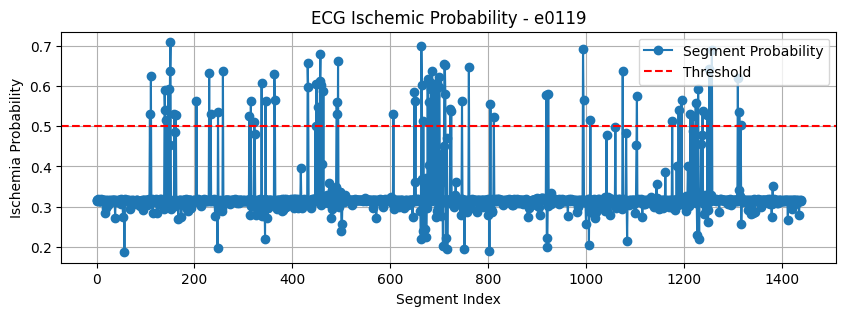


Record: e0133
Max Ischemia Probability: 0.639
Ischemic Burden: 18.8%
Max Consecutive Ischemic Segments: 6
Result: CAD (Ischemia) Detected ✅


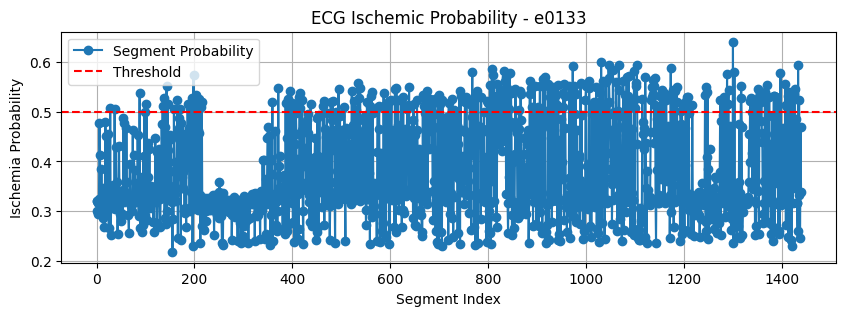

In [107]:
# for test_record in ["e0119", "e0103"]:  # e0119 = non-CAD, e0103 = CAD
#     rec = wfdb.rdrecord(os.path.join(EDB_PATH, test_record))
#     score = predict_ecg(rec.p_signal)
#     print(f"{test_record} → CAD Probability: {score:.3f}")
#     if score >= 0.5:
#         print("Result: CAD (Ischemia) Detected")
#     else:
#         print("Result: No CAD Detected")

# for test_record in ["e0119", "e0103"]:
#     rec = wfdb.rdrecord(os.path.join(EDB_PATH, test_record))

#     result = predict_ecg_clinical(rec.p_signal)

#     print(f"\nRecord: {test_record}")
#     print(f"Max Ischemia Probability: {result['cad_probability']:.3f}")
#     print(f"Ischemic Burden: {result['ischemic_burden']*100:.1f}%")
#     print(f"Max Consecutive Ischemic Segments: {result['max_consecutive_segments']}")

#     if result["cad_detected"]:
#         print("Result: CAD (Ischemia) Detected ✅")
#     else:
#         print("Result: No CAD Detected ❌")

test_records = ["e0119", "e0133"]

for rec_name in test_records:
    rec = wfdb.rdrecord(os.path.join(EDB_PATH, rec_name))
    result = predict_ecg_clinical(rec.p_signal)

    cad_detected = detect_cad_clinical(result)
    non_cad = is_non_cad(result)

    print(f"\nRecord: {rec_name}")
    print(f"Max Ischemia Probability: {result['cad_probability']:.3f}")
    print(f"Ischemic Burden: {result['ischemic_burden']*100:.1f}%")
    print(f"Max Consecutive Ischemic Segments: {result['max_consecutive_segments']}")

    if cad_detected:
        print("Result: CAD (Ischemia) Detected ✅")
    elif non_cad:
        print("Result: Non-CAD (No Ischemia) ❌")
    else:
        print("Result: Indeterminate ⚠️")

    # Optional plotting
    plot_ischemia(result, title=f"ECG Ischemic Probability - {rec_name}")



In [103]:
# def test_ptbxl_record(record_index=None, max_attempts=100):
#     """
#     Test a PTB-XL record for CAD / non-CAD.

#     Args:
#         record_index (int, optional): specific 0-based record index.
#                                       If None, pick a random valid record.
#         max_attempts (int): max tries to find a record with valid segments.
#     """
#     # --- Pick a random record with enough length if None ---
#     if record_index is None:
#         for _ in range(max_attempts):
#             idx = np.random.randint(0, len(X_ptb))
#             if X_ptb[idx].shape[0] >= 1250:  # enough for segmentation
#                 record_index = idx
#                 break
#         else:
#             print("No valid PTB-XL record found with sufficient length.")
#             return

#     signal = X_ptb[record_index]
#     true_label = y_ptb[record_index]

#     # --- Check again for safety ---
#     if signal.size == 0 or signal.shape[0] < 1250:
#         print(f"Record {record_index} is too short for segmentation. Skipping.")
#         return

#     # --- Predict using the model ---
#     result = predict_ecg_clinical(signal)

#     # --- Handle zero segments safely ---
#     if len(result["segment_probs"]) == 0:
#         print(f"Record {record_index} produced zero segments. Skipping.")
#         return

#     cad_detected = detect_cad_clinical(result)
#     non_cad = is_non_cad(result)

#     # --- Print results ---
#     print(f"\nPTB-XL Record Index: {record_index}")
#     print(f"True Label: {'CAD / Ischemia' if true_label==1 else 'Non-CAD / Normal'}")
#     print(f"Max Ischemia Probability: {result['cad_probability']:.3f}")
#     print(f"Ischemic Burden: {result['ischemic_burden']*100:.1f}%")
#     print(f"Max Consecutive Ischemic Segments: {result['max_consecutive_segments']}")

#     if cad_detected:
#         print("Predicted Result: CAD (Ischemia) Detected ✅")
#     elif non_cad:
#         print("Predicted Result: Non-CAD (No Ischemia) ❌")
#     else:
#         print("Predicted Result: Indeterminate ⚠️")

#     # --- Plot ischemic probabilities ---
#     plot_ischemia(result, title=f"PTB-XL Record {record_index} - Ischemic Probability")


In [ ]:
# test_ptbxl_record()

# **Evaluations**

In [111]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

Prepare Test Data

In [112]:
# Prepare Test Data

X_test, y_test = X_val, y_val  # You already have a train/val split
test_ds = ECGDataset(X_test, y_test)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

# Evaluation

model.eval()
all_probs = []
all_labels = []
test_loss = 0.0

with torch.no_grad():
    for x, y in test_loader:
        logits = model(x)
        loss = criterion(logits, y)
        test_loss += loss.item() * len(y)

        probs = torch.sigmoid(logits)
        all_probs.append(probs)
        all_labels.append(y)

test_loss /= len(test_ds)
all_probs = torch.cat(all_probs).cpu().numpy()
all_labels = torch.cat(all_labels).cpu().numpy()

# Binarize predictions using clinical CAD threshold
preds = (all_probs >= 0.6)  # same threshold as detect_cad_clinical

Test Accuracy and Loss

In [113]:
# Accuracy

accuracy = (preds == all_labels).mean()
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

Test Loss: 0.0001
Test Accuracy: 1.36%


Confusion Matrix and Matrices

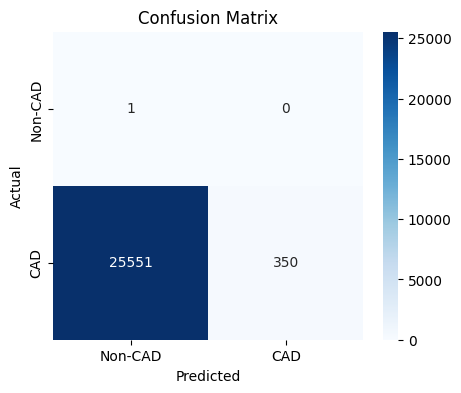

Classification Report:

              precision    recall  f1-score   support

     Non-CAD       0.00      1.00      0.00         1
         CAD       1.00      0.01      0.03     25901

    accuracy                           0.01     25902
   macro avg       0.50      0.51      0.01     25902
weighted avg       1.00      0.01      0.03     25902



In [114]:
# Confusion Matrix

cm = confusion_matrix(all_labels, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-CAD','CAD'], yticklabels=['Non-CAD','CAD'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification Report

print("Classification Report:\n")
print(classification_report(all_labels, preds, target_names=['Non-CAD','CAD']))

ROC Curve + AUC Score

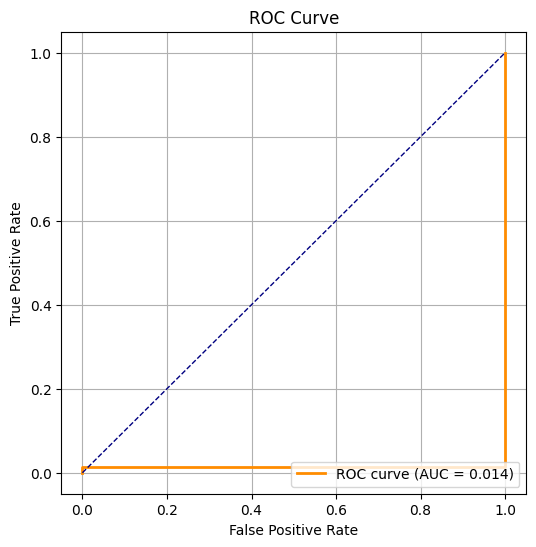

AUC Score: 0.014


In [115]:
# ROC Curve + AUC

fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], color='navy', lw=1, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"AUC Score: {roc_auc:.3f}")